In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sn
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from scipy.signal import hilbert

import json 
import pandas as pd
import numpy as np
import os
import glob

from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed


## Prep

### *variables*

In [6]:
feature_names = [
    "num_iq_samples",
    "amp_mean",
    "amp_std",
    "amp_skew",
    "amp_kurtosis",
    "amp_max",
    "amp_min",
    # "amp_25perc",
    # "amp_50perc",
    # "amp_75perc",
    "psd_mean",
    "psd_std",
    "psd_max",
    "psd_min",
    "spectral_centroid",
    "spectral_bandwidth",
    "spectral_flatness",
    "env_mean",
    "env_std",
    "freq_std"
]
num_features = len(feature_names)
max_files = 45

data_dir = '/Volumes/DRIVE 128GB/iqSamples_Ruko_F11_Pro.csv'
drone_csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
print(drone_csv_files)

chunk_size = 10_000 # how many rows to hold in memory at a time
every_n_rows = 1000

# Example: sample windows with 50% overlap
# window_size = 1024 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 1024 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 2048 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 4096 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
# window_size = 8192 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
# window_size = 16_384 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
# window_size = 32_768 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)

# step = 8192
# step = 4096
# step = 2048
# step = 1024
step = 512

skipSVC = False
skipRF = True

[]


### *functions*

In [7]:
# other 
def getLabelFromFilename(filename): 
    filename = filename.lower()
    if "phantom" in filename: return "Phantom"
    elif "ruko_f11_pro" in filename: return "Ruko_F11_Pro"
    elif "ruko_f11_base" in filename: return "Ruko_F11_base"
    elif "mavic_air_2_" in filename: return "Mavic_Air_2"
    elif "mavic_air_2s" in filename: return "Mavic_Air_2S"
    elif "deerc" in filename: return "DeerC_DE2"
    elif "mini_se" in filename: return "Mini_SE"
    elif "holystone_hs100" in filename: return "Holystone_HS100"
    elif "none" in filename: return "None"
    else: return "unkown_label"



def load_iq(f, chunk_size, every_n_rows):
    # The chunking in this algo is so that we can read in large files (156M lines or more). 
    # In order to reduce compution time, we skip n number of rows. 
    result = pd.DataFrame()

    for chunk in pd.read_csv(f, chunksize=chunk_size):
        result = pd.concat([result, chunk.iloc[::every_n_rows, :]], ignore_index=True)

    # print("THE DF:\n", result)
    result = result[['i', 'q']].to_numpy()
    return result



# metric's functions 
def checkForFilename(base_name): 
    ext = ".txt"
    i = 1
    filename = f"{base_name}-{i}{ext}"
    while os.path.exists(filename):
        filename = f"{base_name}-{i}{ext}"
        i += 1
    return filename



def saveMetricsToFile(base_name, perc_accuracy, model, labels): 
    filename = checkForFilename(base_name)
    with open(filename, "w") as f:
        f.write(f"Model: {model}\n")
        f.write(f"Accuracy: {perc_accuracy:.2f}%\n\n")
        f.write("\n")
        f.write(f"Number of samples: {len(labels)}\n")
        f.write("Count\tLabel\n")
        counts = Counter(labels)
        for item, count in counts.items():
            f.write(f"{count}\t{item}\n")
        f.write("\n")
        f.write("Classification Report:\n")
        f.write(f"{cr}\n\n")
        f.write("Confusion Matrix:\n")
        
        f.write(f"{cm}\n")





In [8]:
# for numpy conversion 

def extractStatFeatures(iq_window, num_iq_samples): 
    """
    This exracts the statistical features from an iq_window number of IQ samples. 
    This creates what we're calling a "derived" feature. 
    """
    f, Pxx = welch(iq_window, nperseg=1024)  # FFT-based PSD
    # Spectral centroid / bandwidth / flatness:
    spectral_centroid = np.sum(f*Pxx)/np.sum(Pxx)
    spectral_bandwidth = np.sqrt(np.sum(Pxx*(f-spectral_centroid)**2)/np.sum(Pxx))
    spectral_flatness = np.exp(np.mean(np.log(Pxx+1e-12)))/np.mean(Pxx+1e-12)
    # Envelope statistics: use Hilbert transform to get instantaneous amplitude
    envelope = np.abs(hilbert(iq_window))
    env_mean = np.mean(envelope)
    env_std  = np.std(envelope)
    # Instantaneous frequency variance (phase derivative)
    phase = np.angle(iq_window)
    inst_freq = np.diff(phase)
    freq_std = np.std(inst_freq)

    sample = [
        int(num_iq_samples),
        np.mean(np.abs(iq_window)),        # mean amplitude
        np.std(np.abs(iq_window)),         # amplitude std
        skew(np.abs(iq_window)),           # skewness
        kurtosis(np.abs(iq_window)),       # kurtosis
        np.max(np.abs(iq_window)),         # max
        np.min(np.abs(iq_window)),         # min
        # np.percentile(np.abs(iq_window),25),
        # np.percentile(np.abs(iq_window),50),
        # np.percentile(np.abs(iq_window),75),
        np.mean(Pxx), np.std(Pxx), np.max(Pxx), np.min(Pxx),      # PSD stats
        spectral_centroid, # spectral
        spectral_bandwidth, # spectral
        spectral_flatness, # spectral
        env_mean, # envelope / freq
        env_std, # envelope / freq
        freq_std # envelope / freq
    ]
    
    return np.array(sample)




def binaryIQToNumpy(meta_file):
    data_file = meta_file.replace("meta", "data")
    label = getLabelFromFilename(meta_file)

    try:
        with open(meta_file, 'r') as f:
            meta = json.load(f)
    except json.JSONDecodeError:
        print(f"Error: {json.JSONDecodeError}")
        return

    dtype_map = {
        "ri8_le":  np.int8,
        "ri16_le": np.int16,
        "ri32_le": np.int32,
        "rf32_le": np.float32,
        "cf32_le": np.complex64,
        "ci8_le":  np.int8,
        "ci16_le": np.int16,
        "ci32_le": np.int32,
    }
    dtype = dtype_map.get(meta["global"]["core:datatype"], np.int16)

    iq = np.fromfile(data_file, dtype=dtype)
    print(f"Converted {(len(iq) // 2):,} IQ samples to numpy array")
    return (iq, meta)





def readInBinDirectoryWithAnnotations(dir, postfix, max_files=100_000): 
    labels = []
    binary_files = glob.glob(os.path.join(dir, "**", "*.sigmf-meta"), recursive=True)
    iq_files = []
    sigmf_meta_files = []
    file_iter = 0

    # first convert the files into a numpy array 
    for file in binary_files:
        if file_iter < max_files: 
            iq_file, sigmf_meta = binaryIQToNumpy(file)
            iq_files.append(iq_file)
            sigmf_meta_files.append(sigmf_meta)
            file_iter += 1
    print(f"Converted {len(sigmf_meta_files)} files")
    
    # Then create a numpy array of the statistical features from the files
    derived_samples, labels = grabStudioLabelsFromIQFiles(iq_files, sigmf_meta_files, labels=labels)
    np.save("derived_samples" + postfix + ".npy", derived_samples)
    return (derived_samples, labels)




def grabStudioLabelsFromIQFiles(iq_files, sigmf_meta_files, labels, max_workers=8):
    print("--------------------------------------------")
    print("\nNow extracting the features\n")

    segments = []

    # Collect all segments first
    for iq_file, meta_file in zip(iq_files, sigmf_meta_files):
        annotations = meta_file["annotations"]
        end = -1

        for ann in annotations:
            # Non-annotated region
            start = end + 1
            end = ann["core:sample_start"] * 2 - 1
            if end > start:
                labels.append("unknown")
                segments.append((iq_file[start:end].copy(), (end - start) // 2))
                # print(f"IQ Samples in seg: {(end - start) // 2}")

            # Annotated region
            start = ann["core:sample_start"] * 2
            end = start + ann["core:sample_count"] * 2
            labels.append(ann["core:label"])
            segments.append((iq_file[start:end].copy(), (end - start) // 2))
            # print(f"IQ Samples in seg: {(end - start) // 2}")

    print(f"Total segments to process: {len(segments):,}")
    print()
    print()
    
    # Parallel feature extractionw
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(extractStatFeatures, seg[0], seg[1]) for seg in segments]
        derived_samples_list = [f.result() for f in futures]  # preserves order

    return np.vstack(derived_samples_list), labels


## Loading Training Dataset

### *Reading in files*

typically this has taken about 70 minutes for 45 files - 75,000 segments 

-11/10/2025 

for 30 files, 66,398 segments it took 63 mins -11/10/2025

In [9]:
# data_dir = '/Volumes/DRIVE 128GB/training'
data_dir = '/home/uav-cyberlab-rfml/RFML/RFML-Code/RFML_Drone_Dataset_2025/old_drone_full_annotated_dataset/*Training*'
derived_samples_training, labels_training = readInBinDirectoryWithAnnotations(data_dir, max_files=max_files, postfix="_training")

Converted 15,625,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 15,625,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 15,625,000 IQ samples to numpy array
Converted 15,625,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 15,625,000 IQ samples to numpy array
Converted 15,625,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 15,625,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array

/tmp/ipykernel_65193/3294619134.py:8: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 26, using nperseg = 26
  f, Pxx = welch(iq_window, nperseg=1024)  # FFT-based PSD
/tmp/ipykernel_65193/3294619134.py:8: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 24, using nperseg = 24
  f, Pxx = welch(iq_window, nperseg=1024)  # FFT-based PSD
/tmp/ipykernel_65193/3294619134.py:8: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 417, using nperseg = 417
  f, Pxx = welch(iq_window, nperseg=1024)  # FFT-based PSD
/tmp/ipykernel_65193/3294619134.py:8: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 22, using nperseg = 22
  f, Pxx = welch(iq_window, nperseg=1024)  # FFT-based PSD
/tmp/ipykernel_65193/3294619134.py:8: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 28, using nperseg = 28
  f, Pxx = welch(iq_window, nperseg=1024)  # FFT-based PSD
/tmp/ipy

### *displaying data*

In [10]:
print(f"Type of derived samples: {type(derived_samples_training)}")
print(f"Shape of derived samples: {derived_samples_training.shape}")
print()
print(f"Type of each sample: {type(derived_samples_training[0])}")
print(f"Number of features in a sample: {derived_samples_training.shape[1]}")
print()
print(f"Type of each feature: {type(derived_samples_training[0][0])}")
print()
print(f"Number of labels: {len(labels_training)}")
print()

print(f"Num IQ's\tLabel")
for i in range(5): 
    print(f"{int(derived_samples_training[i][0]):,}\t\t{labels_training[i]}")
print()
print(f"Two samples: \n{derived_samples_training[:2]}")
# print(f"{derived_samples_training[3][0]}\t\t{labels_training[3]}")

print()
print(f"training Found:")
print("Count\tLabel")
counts = Counter(labels_training)
for item, count in counts.items():
    print(f"{count}\t{item}")


Type of derived samples: <class 'numpy.ndarray'>
Shape of derived samples: (75390, 17)

Type of each sample: <class 'numpy.ndarray'>
Number of features in a sample: 17

Type of each feature: <class 'numpy.float64'>

Number of labels: 75390

Num IQ's	Label
239,435		unknown
128,329		Ocusync_2.0_mavic_air_2_DL
55,281		Ocusync_2.0_mavic_air_2_DL
27,730		unknown
97,271		Ocusync_2.0_mavic_air_2_DL

Two samples: 
[[2.39435000e+05 2.87542640e+03 2.87854526e+03 1.21279086e+00
  1.56733502e+00 2.65730000e+04 0.00000000e+00 3.29494420e+07
  5.03219760e+07 1.49610128e+08 1.92164531e+04 2.55650762e-01
  2.14155626e-01 4.10506614e-02 4.44111265e+03 3.65850163e+03
  2.22550130e+00]
 [1.28329000e+05 4.39884551e+03 3.27997587e+03 9.47812233e-01
  7.24488582e-01 2.56390000e+04 0.00000000e+00 5.97866760e+07
  7.29255040e+07 2.08436448e+08 1.29689312e+05 2.69619754e-01
  2.00596209e-01 2.98952818e-01 6.85989748e+03 3.62737245e+03
  2.28649855e+00]]

training Found:
Count	Label
37592	unknown
466	Ocusync_2.

In [11]:
# Display the table 

if False: 
    print("  ", end="")
    print(" ".join(f"{x:>29}" for x in feature_names))

    np.set_printoptions(threshold=np.inf, linewidth=1000, suppress=True)
    print(np.array2string(
        derived_samples,
        formatter={'float_kind': '                     {:8.0f}'.format},
        max_line_width=12000  # increase line width
    ))

## Random Forest Classifer 

### *preprocessing*

In [12]:
if False: 
    derived_samples_training = np.load('derived_samples_training.npy', allow_pickle=True)

X_train = derived_samples_training
y_train = np.array(labels_training)

print(f"Number of samples: {X_train.shape[0]:,}")
print(f"Number of labels: {len(y_train):,}")

remove_labels_training = [
    'Burst',
    "",
]

mask = ~np.isin(y_train, remove_labels_training)

X_train = X_train[mask]
y_train = y_train[mask]

print(f"\nAfter removing unnecessary labels:")
print(f"Number of samples: {X_train.shape[0]:,}")
print(f"Number of labels: {len(y_train):,}")

le = LabelEncoder()
y_train = le.fit_transform(y_train)

Number of samples: 75,390
Number of labels: 75,390

After removing unnecessary labels:
Number of samples: 75,338
Number of labels: 75,338


### *Fitting*

In [13]:
rf = RandomForestClassifier(n_estimators=200, random_state=123)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### *Loading testing dataset*

In [14]:
# data_dir = '/Volumes/DRIVE 128GB/evaluation'
data_dir = '/home/uav-cyberlab-rfml/RFML/RFML-Code/RFML_Drone_Dataset_2025/old_drone_full_annotated_dataset/*Evaluation*'
derived_samples_test, labels_test = readInBinDirectoryWithAnnotations(data_dir, "_eval", max_files=max_files)

Converted 15,625,000 IQ samples to numpy array
Converted 15,625,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 15,625,000 IQ samples to numpy array
Converted 15,625,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 15,625,000 IQ samples to numpy array
Converted 15,625,000 IQ samples to numpy array
Converted 93,750,000 IQ samples to numpy array
Converted 31,250,000 IQ samples to numpy array
Converted 15,625,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 15,625,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Converted 15,625,000 IQ samples to numpy array
Converted 156,250,000 IQ samples to numpy array
Con

/tmp/ipykernel_65193/3294619134.py:8: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 377, using nperseg = 377
  f, Pxx = welch(iq_window, nperseg=1024)  # FFT-based PSD
/tmp/ipykernel_65193/3294619134.py:8: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 24, using nperseg = 24
  f, Pxx = welch(iq_window, nperseg=1024)  # FFT-based PSD
/tmp/ipykernel_65193/3294619134.py:8: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 837, using nperseg = 837
  f, Pxx = welch(iq_window, nperseg=1024)  # FFT-based PSD
/tmp/ipykernel_65193/3294619134.py:8: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 254, using nperseg = 254
  f, Pxx = welch(iq_window, nperseg=1024)  # FFT-based PSD
/tmp/ipykernel_65193/3294619134.py:8: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 510, using nperseg = 510
  f, Pxx = welch(iq_window, nperseg=1024)  # FFT-based PSD
/t

In [15]:
if False: 
    derived_samples_test = np.load('derived_samples_test.npy', allow_pickle=True)

print(f"Type of derived samples: {type(derived_samples_test)}")
print(f"Shape of derived samples: {derived_samples_test.shape}")
print()
print(f"Type of each sample: {type(derived_samples_test[0])}")
print(f"Number of features in a sample: {derived_samples_test.shape[1]}")
print()
print(f"Type of each feature: {type(derived_samples_test[0][0])}")
print()
print(f"Number of labels: {len(labels_test)}")
print()

print(f"Num IQ's\tLabel")
for i in range(5): 
    print(f"{int(derived_samples_test[i][0]):,}\t\t{labels_test[i]}")
print()
print(f"Two samples: \n{derived_samples_test[:2]}")
# print(f"{derived_samples_test[3][0]}\t\t{labels_test[3]}")

print()
print(f"Eval Found:")
print("Count\tLabel")
counts = Counter(labels_test)
for item, count in counts.items():
    print(f"{count}\t{item}")


Type of derived samples: <class 'numpy.ndarray'>
Shape of derived samples: (43684, 17)

Type of each sample: <class 'numpy.ndarray'>
Number of features in a sample: 17

Type of each feature: <class 'numpy.float64'>

Number of labels: 43684

Num IQ's	Label
28,661		unknown
27,562		DeerC_DE22_Uplink
381,725		unknown
27,401		DeerC_DE22_Uplink
907,565		unknown

Two samples: 
[[ 2.86610000e+04  1.14402421e+01  8.85520574e+00  9.23567302e-01
   8.19576084e-01  6.60000000e+01  0.00000000e+00  3.61715637e+02
   1.43363785e+02  2.34984399e+03  1.23485260e+02  2.55655136e-01
   1.56477555e-01  9.52430010e-01  1.80644296e+01  9.45628778e+00
   2.15047383e+00]
 [ 2.75620000e+04  1.23053198e+03  1.00825311e+03  1.13079685e-01
  -1.42505185e+00  5.56200000e+03  0.00000000e+00  5.12784600e+06
   5.70303640e+07  1.17303974e+09  6.22462158e+02  2.13914523e-01
   1.13881550e-02  2.86799739e-03  1.92621967e+03  1.16242929e+03
   2.06147504e+00]]

Eval Found:
Count	Label
21776	unknown
1425	DeerC_DE22_Uplin

### Prediction

In [16]:
X_test = derived_samples_test
y_test = np.array(labels_test)

print(f"Number of samples: {X_test.shape[0]:,}")
print(f"Number of labels: {len(y_test):,}")

remove_labels = [
    'Ruko_F11_pro_DL',
    'Lightbridge_phantom_3_pro_UL',
    'Lightbridge_phantom_3_pro_DL',
    'Lightbridge_phantom_3_pro'
]

mask = ~np.isin(y_test, remove_labels)

X_test = X_test[mask]
y_test = y_test[mask]

print(f"\nAfter removing invalid labels")
print(f"Number of samples: {X_test.shape[0]:,}")
print(f"Number of labels: {len(y_test):,}")

y_test = le.transform(y_test)
y_pred = rf.predict(X_test)

Number of samples: 43,684
Number of labels: 43,684

After removing invalid labels
Number of samples: 36,168
Number of labels: 36,168


### *Metrics*

In [17]:
accuracy = accuracy_score(y_test, y_pred)
perc_accuracy = accuracy * 100
print(f"Accuracy: {perc_accuracy:.2f}%")
print()
print(f"Number of samples: {len(labels_test)}")
print("Count\tLabel")
counts = Counter(labels_test)
for item, count in counts.items():
    print(f"{count}\t{item}")
print()

cr = classification_report(y_test, y_pred, target_names=le.classes_)
cm = confusion_matrix(y_test, y_pred)
print(cr)
print()
print(cm)
print()

saveMetricsToFile('svc_metrics', perc_accuracy, "Random Forest", labels_training)

Accuracy: 87.20%

Number of samples: 43684
Count	Label
21776	unknown
1425	DeerC_DE22_Uplink
6703	Ocusync_2.0_mini_se_DL
1251	Ocusync_2.0_mavic_air_2_DL
102	Ocusync_2.0_mavic_air_2_UL
2122	Ruko_F11_pro_UL
5914	Ruko_F11_pro_DL
431	Lightbridge_phantom_3_pro_DL
455	Lightbridge_phantom_3_pro_UL
1754	Ocusync_3.0_mavic_air_2s_DL
77	Ocusync_3.0_mavic_air_2s_UL
773	Ruko_F11_Uplink
185	HS100_Downlink
716	Lightbridge_phantom_3_pro

                             precision    recall  f1-score   support

          DeerC_DE22_Uplink       0.80      0.86      0.83      1425
             HS100_Downlink       1.00      1.00      1.00       185
 Ocusync_2.0_mavic_air_2_DL       0.30      0.08      0.13      1251
 Ocusync_2.0_mavic_air_2_UL       0.71      0.90      0.80       102
     Ocusync_2.0_mini_se_DL       1.00      0.97      0.99      6703
Ocusync_3.0_mavic_air_2s_DL       0.72      0.05      0.09      1754
Ocusync_3.0_mavic_air_2s_UL       0.94      0.82      0.88        77
            Ruko_F11_U

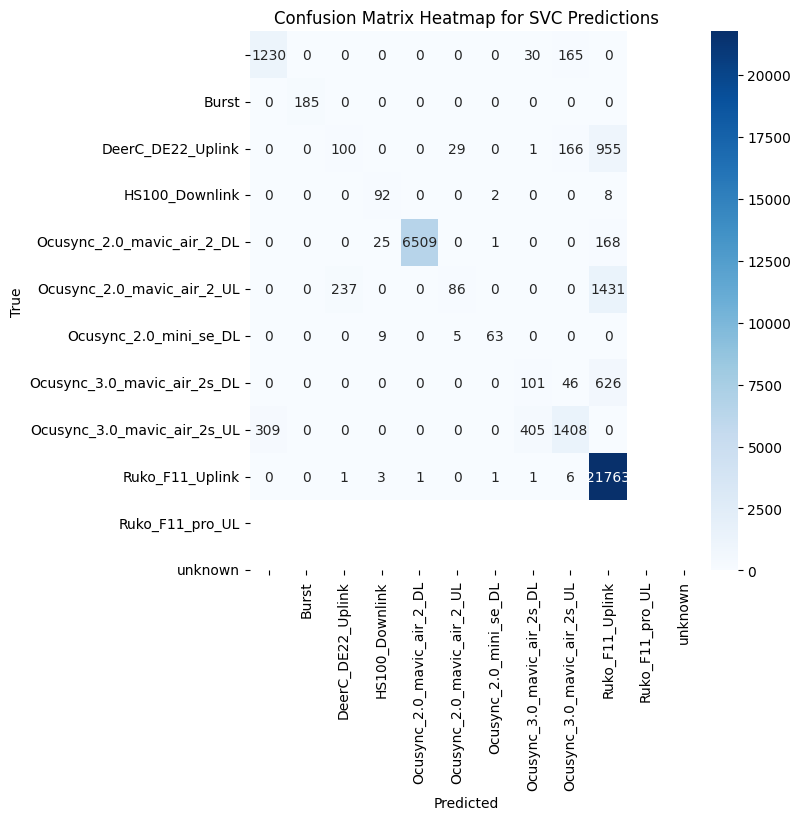

In [18]:
# Create a heatmap of the confusion matrix

plt.figure(figsize=(7, 7))
sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(labels_training), yticklabels=np.unique(labels_training))

# Labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap for SVC Predictions')

plt.show()


spectral_bandwidth    0.175912
spectral_flatness     0.150288
amp_mean              0.088744
env_mean              0.069055
amp_skew              0.066432
psd_std               0.059631
num_iq_samples        0.059291
psd_max               0.056940
amp_kurtosis          0.055456
psd_mean              0.044586
env_std               0.040506
amp_std               0.034534
psd_min               0.031207
spectral_centroid     0.027732
amp_max               0.025745
freq_std              0.013753
amp_min               0.000188
dtype: float64


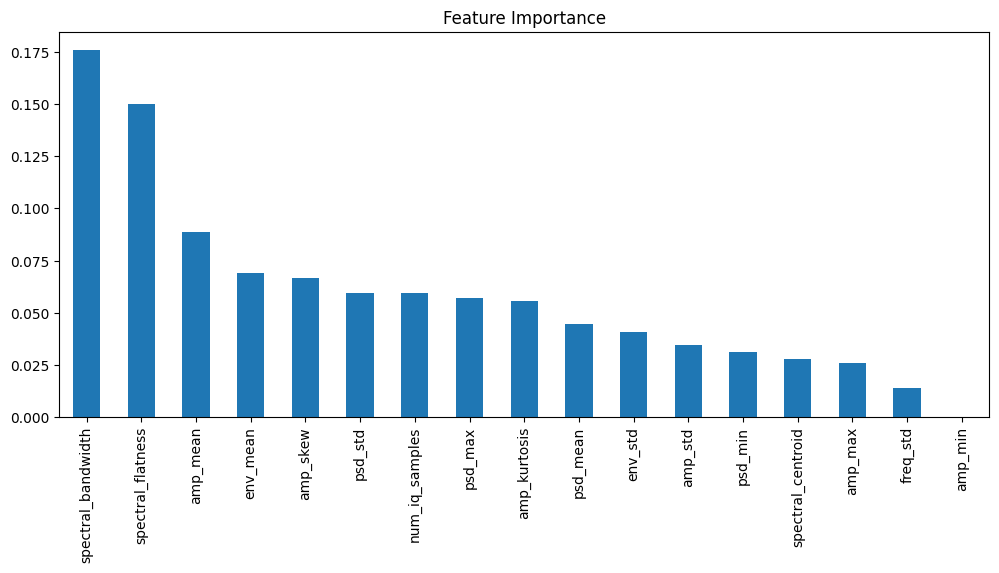

In [19]:
fi = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
print(fi)
fi.plot(kind='bar', figsize=(12,5), title="Feature Importance")
plt.show()


In [20]:
from sklearn.metrics import cohen_kappa_score
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
from sklearn.metrics import matthews_corrcoef
print("MCC:", matthews_corrcoef(y_test, y_pred))


Cohen's Kappa: 0.7654340712298746
MCC: 0.7767193017966071
